Confirming Peak of Epidemic Curve (CPEC)
========================================

An epidemic curve shows frequency of new cases per day. A peak on that curve means the day when highest number of individuals were found to be infected and post that the frequency reduced. Predicting the peak is of significance since it indicates the maximum number of infected patients requiring care at a time. It can help Government prep the healthcare system and also gives a rough estimate on when the epidemic might end. In this study, we look at a couple of models which are predicting peaks and verify whether their predictions are correct.

Recently, Data Driven Innovation lab (DDI) at Singapore University of Technology and Design (SUTD) came out with a model which tries to provide peak dates for various conuntries: https://www.altaveu.com/documents/covid19predictionpaper20200426.pdf

Similarly, Institute for Health Metrics and Evaluation (IHME) at University of Washington (UW) has come up with models which declare peaks for some countries: https://covid19.healthdata.org/

We'll verify whether the peak dates provided by these two models are correct or not. 
Since the peak is a local maximum, the slope of the curve should hit 0.

In [1]:
import pandas as pd
import numpy as np
from matplotlib.dates import date2num

For this study, we've downloaded country-wise data from "Our World In Data": 
https://ourworldindata.org/coronavirus

In [2]:
cols = ['location', 'date', 'total_cases', 'new_cases']
dates = ['date']
df = pd.read_csv("csv/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases
6483,Iran,2020-02-13,0,0


For each country, onset date is considered when number of total cases exceeds 100. 

This is done since data from the initial days is usually noisy.

In [3]:
# consider days when total_cases exceeded 100
fdf = df.loc[df['total_cases']>100]

In [60]:
def calc_peak(df, country='India', plot=True, save=False):
    # filter sort and prep data
    grp_df = df.loc[df['location']==country]
    grp_df = grp_df.sort_values(by='date')
    grp_df.reset_index(inplace=True, drop=True)
    
    # calc daily new cases avg and normalise to pct
    grp_df['new_cases_pct'] = grp_df['new_cases'] / grp_df['new_cases'].max() * 100
    
    # calc change in new cases, smoothened over a period of 6 days
    grp_df['avg_new_cases_pct'] = grp_df['new_cases_pct'].rolling(6, min_periods=1, center=True).mean().rolling(6, min_periods=1, center=True).mean()
    grp_df['delta_new_cases_pct'] = (grp_df['avg_new_cases_pct'].shift(-3) - grp_df['avg_new_cases_pct'].shift(3, fill_value=0)) / 6
    
    # calc slope in degrees, assuming 5 pct per day growth = 45 deg slope. then smoothen over 6 days
    grp_df['slope'] = np.degrees(np.arctan(grp_df['delta_new_cases_pct'] / 5))
    grp_df['slope'] = grp_df['slope'].rolling(6, min_periods=1, center=True).mean()

    # calc second order change
    grp_df['delta_slope'] = (grp_df['slope'].shift(-3) - grp_df['slope'].shift(3, fill_value=0))
    
    # calc peaks, i.e. when slope is 0
    sign_change = np.nonzero(np.abs(np.diff(np.sign(grp_df['slope'].interpolate(method='pad')))))[0]
    peaks = grp_df.loc[sign_change]
    
    # filter noise using second order derivative
    peaks = peaks.loc[peaks['delta_slope'] < 0]
    
    # use highest peak in case multiple peaks found
    peak = peaks.loc[peaks['avg_new_cases_pct'].idxmax()] if len(peaks) else None
    
    # return if plotting not required
    if not plot:
        return peak
    
    # plot all 3 cols as subplots
    ax_new_pct, ax_slp = grp_df.plot(
        x = 'date',
        y = ['new_cases_pct', 'slope'],
        title = [country + l for l in [': Pct daily new cases', ': Slope (in degrees) of new cases']],
        grid = True,
        figsize = (9,7),
        subplots = True,
        sharex = False
    )
    
    # add moving avg to new_cases chart
    grp_df.plot(x = 'date', y = 'avg_new_cases_pct', grid = True, ax = ax_new_pct)
    # add x axis to change_in_new_cases chart
    ax_slp.axhline(y=0, linewidth=2, color='r')
    
    # add vertical line when peak hit
    if not peak is None:
        for ax in [ax_new_pct, ax_slp]:
            ax.axvline(x=peak['date'], linewidth=2, color='r')
    
    # save charts to docs folder
    if save:
        ax_slp.get_figure().savefig("docs/assets/images/02/" + country.lower().replace(" ", "_") + ".png")
    
    return peak

In [5]:
# Data from University of Washington and Singapore University of Technology and Design
COUNTRY_DATA = [
    {
        "location": "India",
        "uw_peak": "",
        "sutd_peak": "2020-04-20"
    },
    {
        "location": "China",
        "uw_peak": "",
        "sutd_peak": "2020-02-08"
    },
    {
        "location": "South Korea",
        "uw_peak": "",
        "sutd_peak": "2020-03-02"
    },
    {
        "location": "United States",
        "uw_peak": "2020-04-15",
        "sutd_peak": "2020-04-10"
    },
    {
        "location": "Brazil",
        "uw_peak": "",
        "sutd_peak": "2020-04-21"
    },
    {
        "location": "United Kingdom",
        "uw_peak": "2020-04-10",
        "sutd_peak": "2020-04-12"
    },
    {
        "location": "Italy",
        "uw_peak": "2020-03-27",
        "sutd_peak": "2020-03-29"
    },
    {
        "location": "Spain",
        "uw_peak": "2020-04-01",
        "sutd_peak": "2020-04-02"
    },
    {
        "location": "Germany",
        "uw_peak": "2020-04-16",
        "sutd_peak": "2020-04-01"
    },
    {
        "location": "France",
        "uw_peak": "2020-04-05",
        "sutd_peak": "2020-04-03"
    },
    {
        "location": "Portugal",
        "uw_peak": "2020-04-03",
        "sutd_peak": "2020-04-06"
    },
    {
        "location": "United Arab Emirates",
        "uw_peak": "",
        "sutd_peak": "2020-04-27"
    },
    {
        "location": "Saudi Arabia",
        "uw_peak": "",
        "sutd_peak": "2020-04-27"
    },
    {
        "location": "Pakistan",
        "uw_peak": "",
        "sutd_peak": "2020-04-27"
    }
]

,country,cpec,uw,sutd
0,India,Peak not hit,,2020-04-20
1,China,2020-02-13,,2020-02-08
2,South Korea,2020-03-03,,2020-03-02
3,United States,2020-04-10,2020-04-15,2020-04-10
4,Brazil,Peak not hit,,2020-04-21
5,United Kingdom,2020-04-15,2020-04-10,2020-04-12
6,Italy,2020-03-26,2020-03-27,2020-03-29
7,Spain,2020-04-01,2020-04-01,2020-04-02
8,Germany,2020-04-03,2020-04-16,2020-04-01
9,France,2020-04-02,2020-04-05,2020-04-03


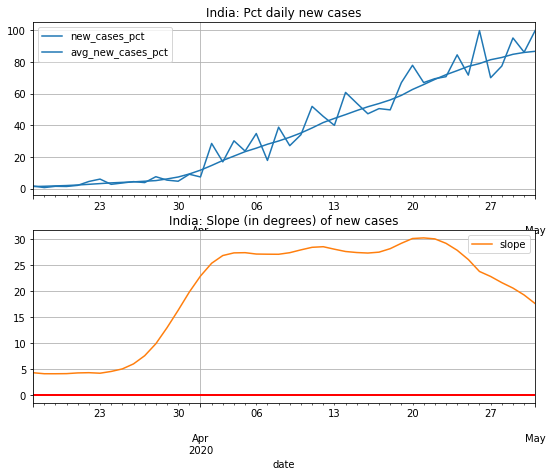

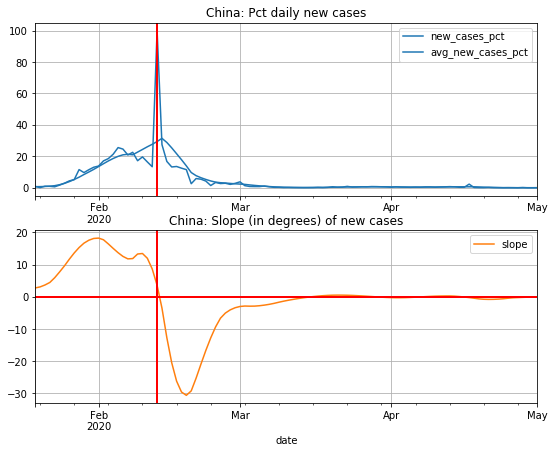

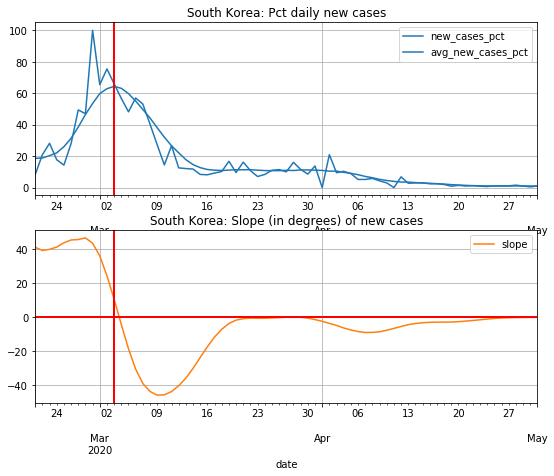

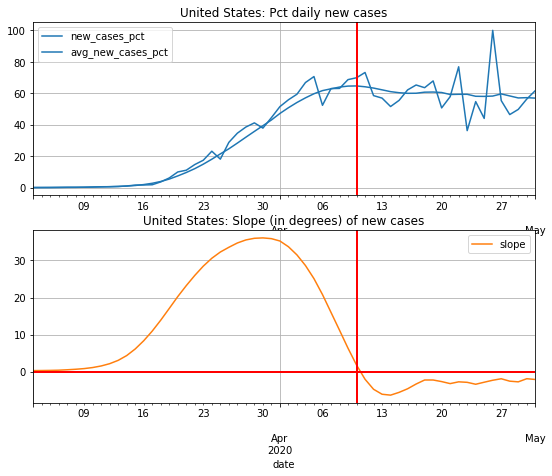

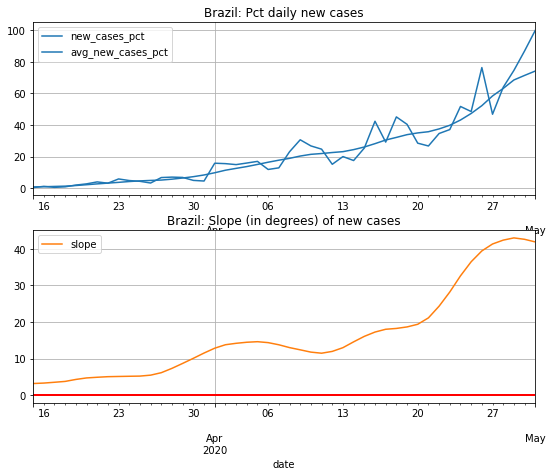

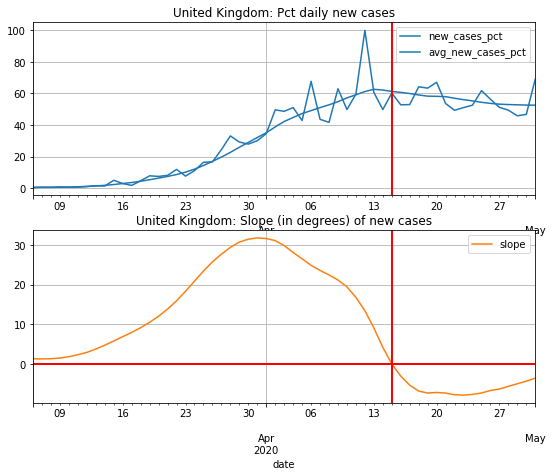

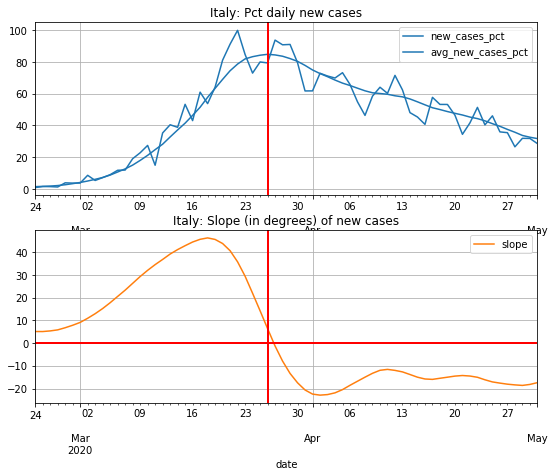

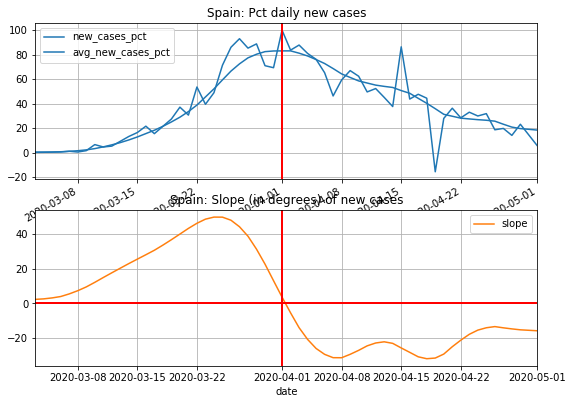

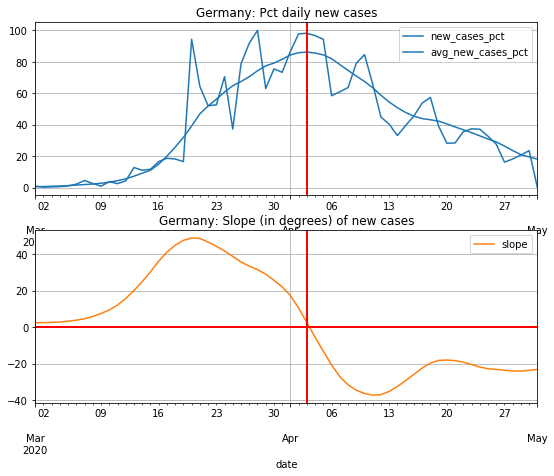

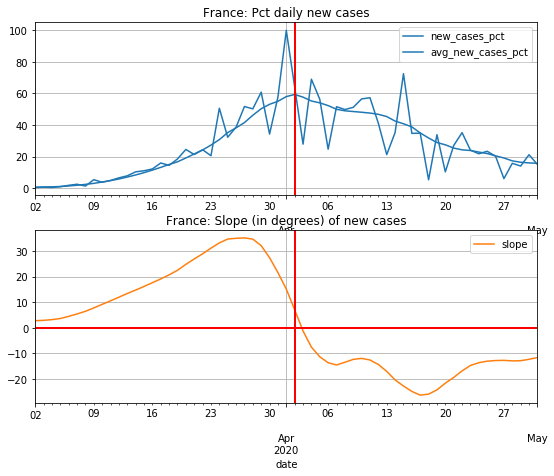

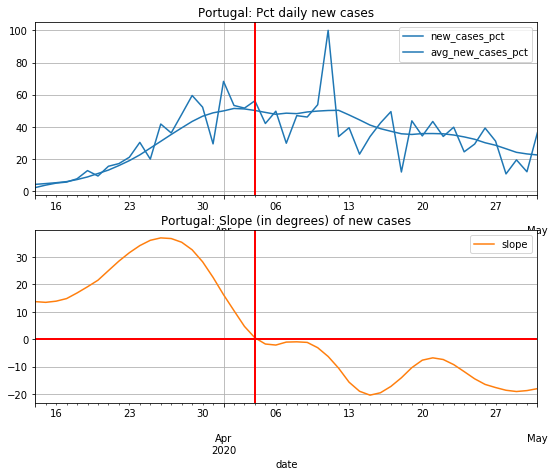

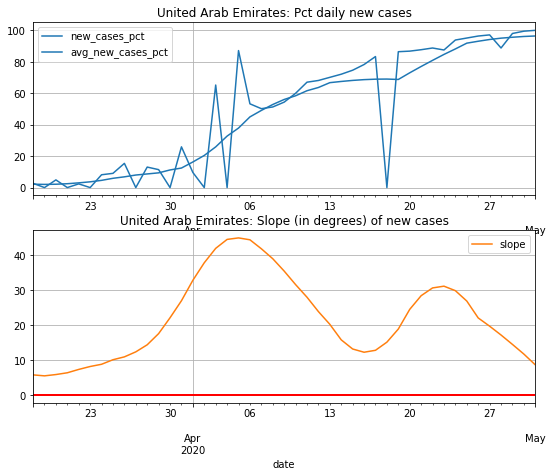

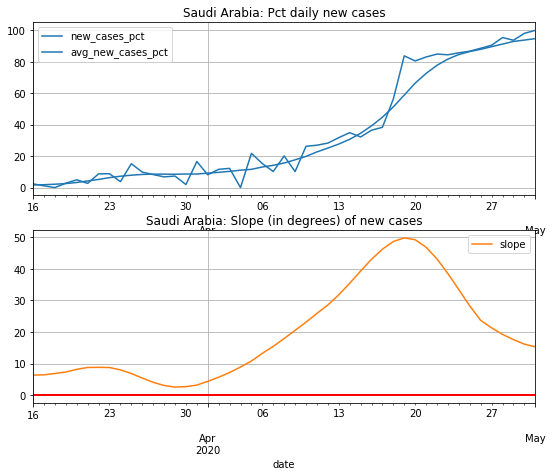

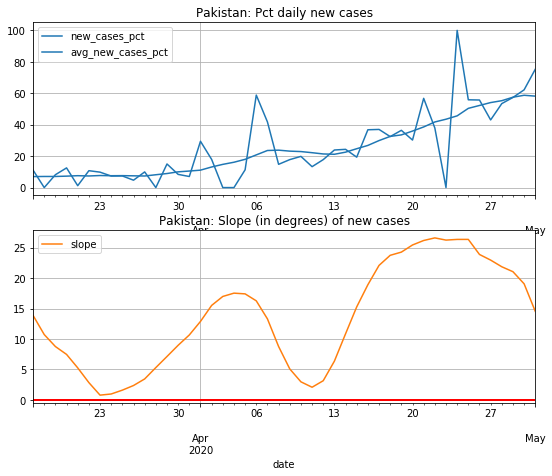

In [61]:
country = []
cpec = []
uw = []
sutd = []
for c in COUNTRY_DATA:
    result = 'Peak not hit'
    peak = calc_peak(fdf, c['location'], True, False)
    if not peak is None:
        result = str(peak['date'].date())
    country.append(c['location'])
    cpec.append(result)
    uw.append(c['uw_peak'])
    sutd.append(c['sutd_peak'])

pd.DataFrame({
    "country": country,
    "cpec": cpec,
    "uw": uw,
    "sutd": sutd
})